# Imports

In [9]:
# %load_ext autoreload
# %autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
from sklearn.metrics import jaccard_score
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset, get_dataloaders
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix
from pytorch_tools.tta_wrapper import TTA

In [11]:
import yaml
from src.utils import MODEL_FROM_NAME
from src.utils import TargetWrapper
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy
from src.utils import criterion_from_list
from src.utils import ToCudaLoader

# Get dataloaders

In [4]:
BS = 32
train_dtld_gpu , val_dtld_gpu = get_dataloaders(
    [
        "tier1", 
#         "tier2"
    ],
    batch_size=BS
)


Using datasets: ['tier1']. Train size: 25281. Val size 4381.


# Results exploration

In [137]:
def auto_canny(image, sigma=0.33, fixed_thr=False):
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
#     image = cv2.blur(image, (11, 11))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    if fixed_thr:
        lower, upper = 160, 200
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return np.stack([edged] * 3, axis=2) / 255


In [37]:
PREV_WEIGHTS = None
PREDS = None
PREDS_TTA = None

MEAN=(0.485, 0.456, 0.406)
STD=(0.229, 0.224, 0.225)

LOADER = iter(val_dtld_gpu)
# LOADER = val_dtld_inria_gpu
IMGS, MASKS = next(LOADER)

SZ = 512
test_loader = DataLoader(OpenCitiesTestDataset(get_aug("test", size=SZ)), batch_size=BS, shuffle=True)
TEST_LOADER = iter(test_loader)
_, IMGS , _ = next(TEST_LOADER)
MASKS = torch.zeros_like(IMGS)
IMGS, MASKS = IMGS.cuda(), MASKS.cuda()

In [47]:
SINGLE_IMG, SINGLE_PRED = None, None

In [150]:
@interact(
    weights=sorted(os.listdir("logs/")),
    N=widgets.IntSlider(min=0, max=BS-1, continuous_update=True),
    thr=widgets.FloatSlider(0.5, min=0.2, max=0.8, step=0.1, continuous_update=False),
)
def foo(weights=None, N=0, thr=0.5, adaptive_thr=False, use_tta=False, equilize=False, detect_edges=False, watershed=False, overlay_pred=False):
    global PREV_WEIGHTS
    global PREDS
    global PREDS_TTA
    global SINGLE_IMG
    global SINGLE_PRED
#     global PREV_IMGS_MASKS_PREDS
    
    if weights is None:
        print("select weights")
        return 
    
    if weights != PREV_WEIGHTS:
        PREV_WEIGHTS = weights
        log_path = "logs/" + weights + "/"
        config = yaml.load(open(log_path + "config.yaml"))
        model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
        model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)
        model.eval()
        tta_model = pt.tta_wrapper.TTA(model, segm=True, h_flip=True, rotation=[90], merge="mean", activation="sigmoid")
        with torch.no_grad():
            PREDS = model(IMGS).cpu().detach().sigmoid()
            PREDS_TTA = tta_model(IMGS).cpu().detach()#.sigmoid()
        del model
        del tta_model

    img = to_numpy(IMGS[N]).swapaxes(0, 2)
    img = np.clip((img * STD + MEAN), 0, 1)
    if equilize:
        img = albu.Equalize(always_apply=True, by_channels=False)(image=(img * 255).astype(np.uint8))["image"] / 255
    
    mask = to_numpy(MASKS[N]).swapaxes(0, 2)
    mask[:, :, :2] = (mask[:, :, :2] + 1) * 0.5
    P = PREDS_TTA if use_tta else PREDS
    pred = np.repeat(to_numpy(P[N]), 3, 0).swapaxes(0, 2)
    if detect_edges:
        img = auto_canny(img, fixed_thr=True, sigma=0.5)
        pred = auto_canny(pred, fixed_thr=True)
    thr_mask = (pred > thr).astype(np.uint8)
    if adaptive_thr:
        thr_mask = cv2.threshold(
            (pred[:, :, 0] * 255).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU
        )[1] / 255
#         thr_mask = cv2.adaptiveThreshold(
#             (pred[:, :, 0] * 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, 7
#         ) / 255.
        thr_mask = np.stack([thr_mask,] * 3, axis=2)
#         thr_mask[pred < 1e-3] = 0
    score = jaccard_score(mask[:,:, 2], thr_mask[:,:,2], average="micro")
    if mask[:,:, 2].sum() == 0 and thr_mask[:,:,2].sum() == 0:
        score = 1
    if watershed: 
        img, pred = watershed(img, pred)
    if overlay_pred:
        img[thr_mask == 1] = 1
    stacked = np.hstack([img, mask, pred, thr_mask])
    plt.figure(figsize=(32,8))
    plt.imshow(stacked, cmap="gray")
    plt.title(f"Jaccard={score:.3f}")
    plt.axis("off")
    SINGLE_IMG = img
    SINGLE_PRED = pred

interactive(children=(Dropdown(description='weights', options=('10.bifpn_2l_2dtst_reduced_focal_20200303_20232…

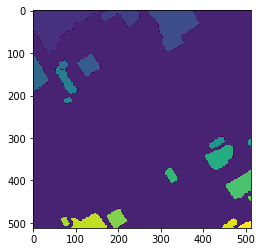

In [146]:

def watershed(image, pred):
    image = (image * 255).astype(np.uint8)
#     image = cv2.GaussianBlur(image, (11, 11), 3)
    smooth_image = cv2.pyrMeanShiftFiltering(image, 21, 51)
    kernel = np.ones((5,5),np.uint8)
    sure_bg = (pred[:, :, 0] < 0.15).astype(np.uint8)
    sure_fg = cv2.morphologyEx((pred[:,:,0] > 0.5).astype(np.uint8), cv2.MORPH_ERODE, kernel)
    unknown = np.logical_not(np.logical_xor(sure_bg, sure_fg))
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown] = 0
#     markers = cv2.watershed(image.astype(np.uint8), markers)
    markers = cv2.watershed((pred * 255).astype(np.uint8), markers)
#     image[markers == -1] = [255,0,0]
    return markers

plt.imshow(watershed(SINGLE_IMG, SINGLE_PRED))

# Test Results Exploration